In [ ]:
import scanpy as sc
import anndata as ad
import cellanova as cnova
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import matplotlib.ticker as ticker
mpl.rcParams['font.family'] = 'Arial'
figpath = '../figures/figure3'
os.mkdir(figpath)
datapath = '../data'
#find the best params
def clu(adata, key_added="majorType-fix", n_neighbors=50, n_pcs=30, rep='X_pca_harmony', do_har=False, max_iter=20, do_scrublet=False, har_key='batch', resolution=1):
    # Computing the neighborhood graph
    if do_scrublet:
        n0 = adata.shape[0]
        print("{0} Cell number: {1}".format(key_added, n0))
        sc.external.pp.scrublet(adata)
        adata = adata[adata.obs['predicted_doublet']==False,:].copy()
        print("{0} Cells retained after scrublet, {1} cells reomved.".format(adata.shape[0], n0-adata.shape[0]))
    else:
        print("Ignoring processing doublet cells...")
    # sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=True)
    if do_har and len(adata.obs[har_key].cat.categories) > 1:
        sc.external.pp.harmony_integrate(adata, key=har_key,max_iter_harmony=max_iter)
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    else:
        print("Evaluating neighbors only...")
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, use_rep=rep)
    # Run UMAP
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=resolution, key_added=key_added)
    sc.pl.umap(adata, color=key_added, legend_fontoutline=True, palette=sc.pl.palettes.default_20, legend_loc="on data")
    return adata

/home/rzh/BCY/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==59.6.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


In [55]:
adata_concat = sc.read_h5ad(f'{datapath}/adata-epi-concat.h5ad')
adata_concat

/home/rzh/miniconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1791: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 76216 × 17269
    obs: 'batch', 'age', 'majorType-fix', 'IHC', 'study', 'annotation', 'cnv_score', 'cnv_status', 'leiden-1', 'ori.annotation'
    var: 'n_cells-Non-young', 'highly_variable-Non-young', 'means-Non-young', 'dispersions-Non-young', 'dispersions_norm-Non-young', 'type-Non-young', 'n_cells_by_counts-Young', 'mean_counts-Young', 'log1p_mean_counts-Young', 'pct_dropout_by_counts-Young', 'total_counts-Young', 'log1p_total_counts-Young', 'n_cells-Young', 'highly_variable-Young', 'means-Young', 'dispersions-Young', 'dispersions_norm-Young', 'symbol-Young', 'ensg-Young', 'chromosome-Young', 'start-Young', 'end-Young', 'n_cells_by_counts-Young-inter', 'mean_counts-Young-inter', 'log1p_mean_counts-Young-inter', 'pct_dropout_by_counts-Young-inter', 'total_counts-Young-inter', 'log1p_total_counts-Young-inter', 'n_cells-Young-inter', 'highly_variable-Young-inter', 'means-Young-inter', 'dispersions-Young-inter', 'dispersions_norm-Young-inter', 'type-

In [3]:
def anno(adata:ad.AnnData, annoDict:dict, obsKey='cnv_status', obsVal='cnv_leiden', default="Unknown"):
  if default is not None:
    adata.obs[obsKey] = default
  for key in annoDict.keys():
    adata.obs.loc[adata.obs[obsVal].isin(annoDict[key]), obsKey] = key
  return adata

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


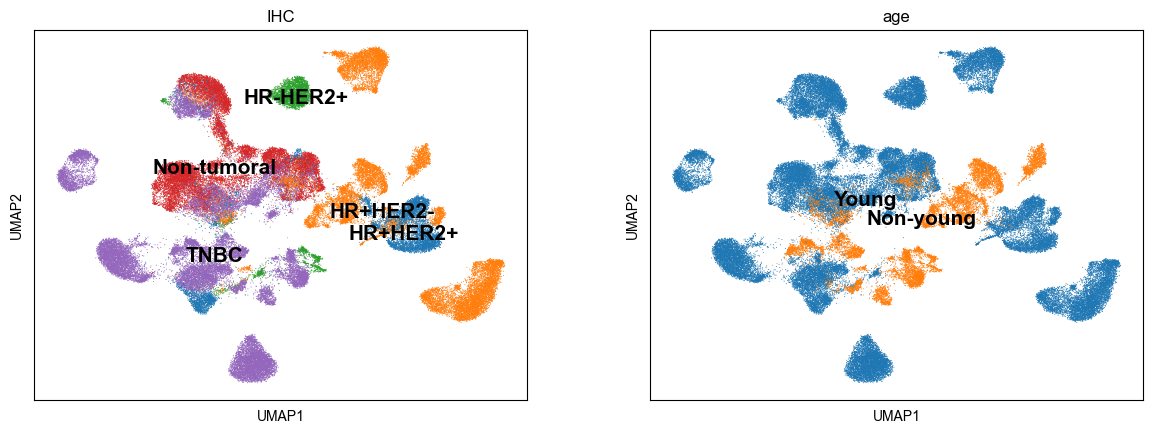

In [19]:
annoDict = {
  'Non-tumoral': ['5N', '6N', '10N', '12N', '16N'],
  'TNBC': ['1T', '2T', '3T', '8T', '9T', 'CID44991', 'CID4513', 'CID4523', 'CID44971', 'CID4495', 'CID4465','CID44041','CID3946','GSM4909288_TNB1_0177', 'GSM4909287_TNB1_0554', 'GSM4909285_TNB1_4031', 'CID4515'],
  'HR+HER2-': ['5T', '6T', '10T', '15T', 'CID4535', 'CID4067', 'CID4463', 'CID4530N', 'CID4471', 'CID3948','CID4290A','CID4461','CID3941','CID3963','CID4040','CID4398',],
  'HR+HER2+': ['20T', '21T', '22T', 'CID4066', 'CID3586',],
  'HR-HER2+': ['17T', 'CID45171', 'CID3921','GSM4909289_HER2_0308'],
}
adata_concat = anno(adata_concat, annoDict, 'IHC', 'batch')
sc.pl.umap(adata_concat, color=['IHC', 'age'], size=2, legend_loc='on data', legend_fontsize=15)

In [18]:
adata_concat.obs.loc[adata_concat.obs['batch'].isin(['GSM4909288_TNB1_0177', 'GSM4909287_TNB1_0554', 'GSM4909285_TNB1_4031','GSM4909289_HER2_0308']), 'age'] = 'Young'

In [54]:
adata_epi_norm = sc.read_h5ad(f"{datapath}/adata-epi-norm.h5ad")
adata_epi_norm

AnnData object with n_obs × n_vars = 15756 × 39735
    obs: 'batch', 'mt_frac', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'leiden', 'major_type', 'molecular_type', 'leiden_harmony', 'major_type_harmony', 'minor_type', 'minor-type', 'gender', 'doublet_score', 'predicted_doublet', 'leiden-harmony-female', 'majorType-Female', 'epi-subtype', 'majorType-fix', 'cnv_leiden', 'cnv_score', 'cnv_status', 'IHC', 'epi-leiden', 'epi-normtype'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'symbol', 'ensg', 'chromosome', 'start', 'end'
    uns: 'CellphoneDB', 'IHC_colors', 'batch_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'dendrogram_epi-leiden', 'dendrogram_leiden', 'epi-leiden_colors', 'epi-normtype_colors', 'epi-subtype_colors', 'gender_colors', 

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


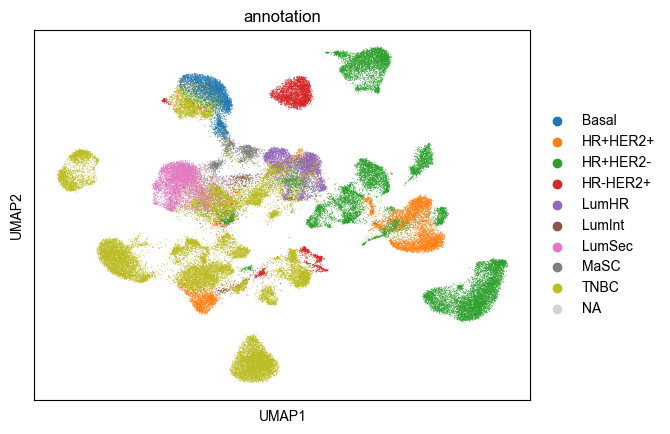

In [47]:
adata_concat.obs['annotation'] = adata_epi_norm.obs['epi-normtype']
adata_concat.obs['annotation'] = list(adata_concat.obs['annotation'])
annoDict = {
  'TNBC': ['1T', '2T', '3T', '8T', '9T', 'CID44991', 'CID4513', 'CID4523', 'CID44971', 'CID4495', 'CID4465','CID44041','CID3946','GSM4909288_TNB1_0177', 'GSM4909287_TNB1_0554', 'GSM4909285_TNB1_4031', 'CID4515'],
  'HR+HER2-': ['5T', '6T', '10T', '15T', 'CID4535', 'CID4067', 'CID4463', 'CID4530N', 'CID4471', 'CID3948','CID4290A','CID4461','CID3941','CID3963','CID4040','CID4398',],
  'HR+HER2+': ['20T', '21T', '22T', 'CID4066', 'CID3586',],
  'HR-HER2+': ['17T', 'CID45171', 'CID3921','GSM4909289_HER2_0308'],
}
adata_concat = anno(adata_concat, annoDict, 'annotation', 'batch', default=None)
sc.pl.umap(adata_concat, color=['annotation'])

In [51]:
adata_concat = adata_concat[adata_concat.obs['annotation'].isin(['TNBC', 'LumHR', 'LumSec', 'Basal', 'MaSC', 'LumInt', 'HR+HER2-', 'HR-HER2+', 'HR+HER2+'])]

/home/rzh/BCY/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


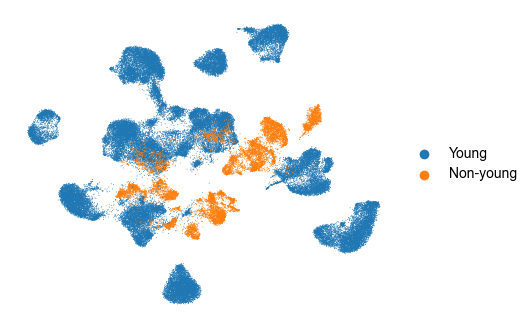

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sc.pl.umap(adata_concat, color=['age'], show=False, ax=ax, title='')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlabel("")
ax.set_ylabel("")
# ax.legend(  handletextpad=0.5, frameon=False,
#                     borderpad=0.6,
#                     columnspacing=1.3,
#                     handlelength=0.65, fontsize=12)
fig.savefig(f"{figpath}/S3b-epiAge.png", dpi=400, bbox_inches='tight')

In [ ]:
# 2025.1.2 correlation_matrix
samples = adata_concat.obs['batch'].cat.categories
norm_type = ['LumSec','LumHR', 'LumInt', 'Basal', 'MaSC',]
corr_mat = pd.DataFrame(columns=norm_type)
for s in samples:
  if s not in ['5N', '6N', '10N', '12N', '16N']:
    adata_temp = adata_concat[(adata_concat.obs['batch'] == s) | adata_concat.obs['annotation'].isin(norm_type), :]
    sc.tl.dendrogram(adata_temp, groupby='annotation')
    cat_ordered = adata_temp.uns['dendrogram_annotation']['categories_ordered']
    corr_df = pd.DataFrame(adata_temp.uns['dendrogram_annotation']['correlation_matrix'], index=cat_ordered, columns=cat_ordered)
    subtype = [x for x in cat_ordered if x not in norm_type]
    if len(subtype) == 0:
      print(f"No specific epithelial for sample: {s}.")
      continue
    else:
      subtype = subtype[0]
      corr = corr_df.loc[subtype, norm_type]
      corr_mat.loc[s, :] = corr
corr_mat

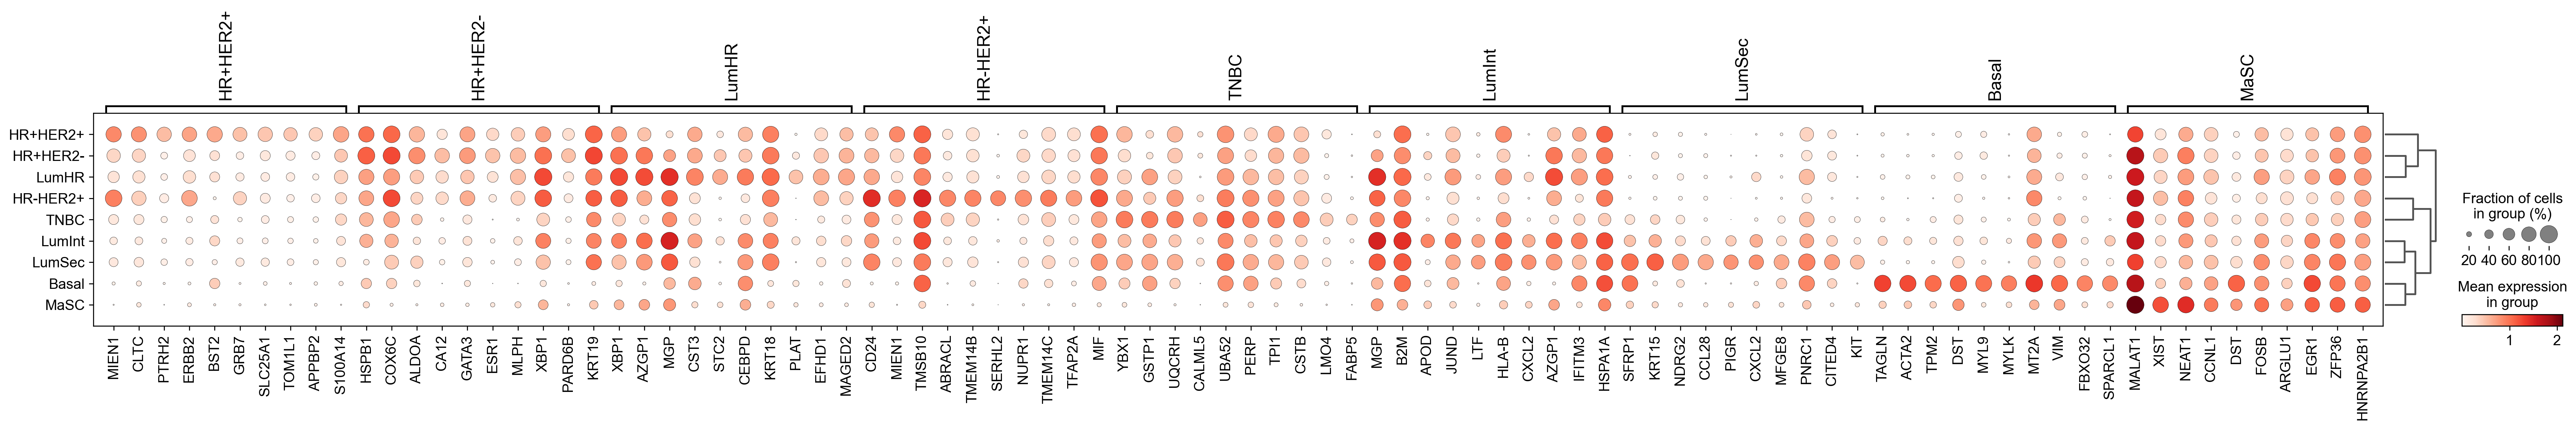

In [268]:
sc.pl.rank_genes_groups_dotplot(adata_concat, groupby='annotation')

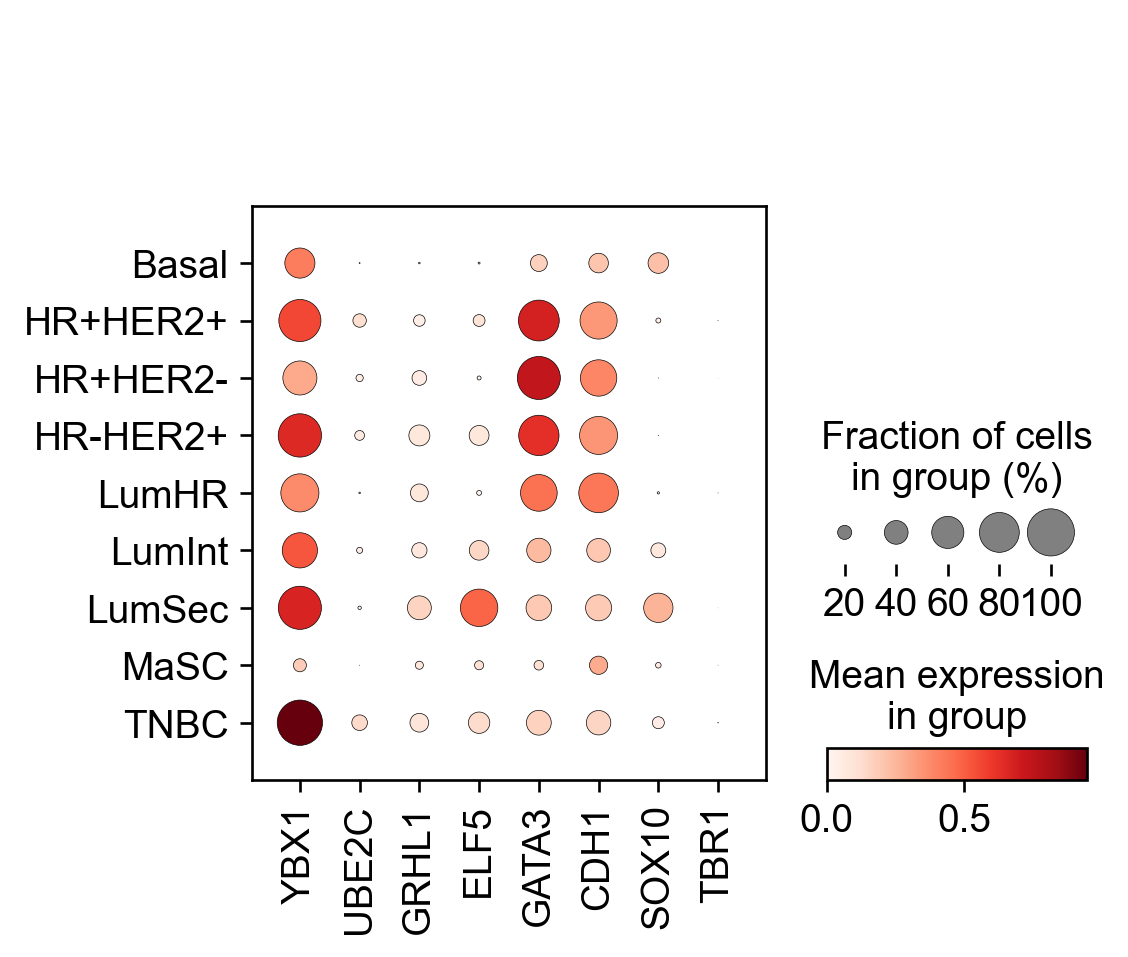

In [269]:
sc.pl.dotplot(adata_concat, groupby='annotation', var_names=['YBX1', 'UBE2C', 'GRHL1', 'ELF5', 'GATA3', 'CDH1', 'SOX10', 'TBR1'])

In [40]:
from scipy.stats import spearmanr, pearsonr

In [310]:
# correlation matrix
cat = adata_concat.obs['annotation'].cat.categories
cat_len = len(cat)
correlation_matrix, pval_matrix = np.zeros((cat_len, cat_len)), np.zeros((cat_len, cat_len))
for i in range(len(cat)):
  x = np.array(adata_concat[adata_concat.obs['annotation'] == cat[i], adata_concat.var['highly_variable']].X.mean(axis=0))[0]
  for j in range(len(cat)):
    if len(adata_temp) > 0:
      y = np.array(adata_concat[adata_concat.obs['annotation'] == cat[j], adata_concat.var['highly_variable']].X.mean(axis=0))[0]
      correlation, p_value = pearsonr(x, y)
      correlation_matrix[i,j] = correlation
      pval_matrix[i,j] = p_value
corr_mt = pd.DataFrame(correlation_matrix, index=cat, columns=cat)
pval_mt = pd.DataFrame(pval_matrix, index=cat, columns=cat)
corr_mt

,Basal,HR+HER2+,HR+HER2-,HR-HER2+,LumHR,LumInt,LumSec,MaSC,TNBC
Basal,1.000000,0.514522,0.481205,0.396965,0.555414,0.684794,0.600933,0.742015,0.584022
HR+HER2+,0.514522,1.000000,0.848288,0.715959,0.774004,0.737939,0.630993,0.554801,0.726740
HR+HER2-,0.481205,0.848288,1.000000,0.748269,0.867372,0.749153,0.596541,0.620922,0.650517
HR-HER2+,0.396965,0.715959,0.748269,1.000000,0.709583,0.652492,0.570736,0.476127,0.725566
LumHR,0.555414,0.774004,0.867372,0.709583,1.000000,0.854007,0.707333,0.726532,0.662667
LumInt,0.684794,0.737939,0.749153,0.652492,0.854007,1.000000,0.848458,0.748278,0.759919
LumSec,0.600933,0.630993,0.596541,0.570736,0.707333,0.848458,1.000000,0.700910,0.738862
MaSC,0.742015,0.554801,0.620922,0.476127,0.726532,0.748278,0.700910,1.000000,0.559315
TNBC,0.584022,0.726740,0.650517,0.725566,0.662667,0.759919,0.738862,0.559315,1.000000


In [ ]:
corr_mt.to_csv(f"{figpath}TableS10.csv")

In [ ]:
# batch correlation matrix
cat = adata_concat.obs['annotation'].cat.categories
cat_len = len(cat)
norm_type = ['LumSec','LumHR', 'LumInt', 'Basal', 'MaSC',]
bat = adata_concat.obs['batch'].cat.categories
correlation_matrix, pval_matrix = np.zeros((cat_len,len(bat))), np.zeros((cat_len,len(bat)))
for i in range(len(cat)):
  x = np.array(adata_concat[adata_concat.obs['annotation'] == cat[i], adata_concat.var['highly_variable']].X.mean(axis=0))[0]
  for j in range(len(bat)):
    if bat[j] not in ['5N', '6N', '10N', '12N', '16N']:
      adata_temp = adata_concat[~adata_concat.obs['annotation'].isin(norm_type) & np.array(adata_concat.obs['batch'] == bat[j]), adata_concat.var['highly_variable']]
      if len(adata_temp) > 0:
        print(f"{len(adata_temp)} specific epithelial for batch: {bat[j]}")
        y = np.array(adata_temp.X.mean(axis=0))[0]
        correlation, p_value = pearsonr(x, y)
        correlation_matrix[i,j] = correlation
        pval_matrix[i,j] = p_value
      else: 
        print(f"no specific epithelial for batch: {bat[j]}")
corr_df = pd.DataFrame(correlation_matrix, index=cat, columns=bat)
pval_df = pd.DataFrame(pval_matrix, index=cat, columns=bat)
corr_df

2453 specific epithelial for batch: 1T
2281 specific epithelial for batch: 2T
54 specific epithelial for batch: 3T
898 specific epithelial for batch: 5T
3984 specific epithelial for batch: 6T
4643 specific epithelial for batch: 8T
311 specific epithelial for batch: 9T
6895 specific epithelial for batch: 10T
692 specific epithelial for batch: 15T
367 specific epithelial for batch: 17T
618 specific epithelial for batch: 20T
4116 specific epithelial for batch: 21T
1384 specific epithelial for batch: 22T
20 specific epithelial for batch: CID3586
213 specific epithelial for batch: CID3921
89 specific epithelial for batch: CID3941
4 specific epithelial for batch: CID3946
141 specific epithelial for batch: CID3948
126 specific epithelial for batch: CID3963
2 specific epithelial for batch: CID4040
293 specific epithelial for batch: CID4066
1185 specific epithelial for batch: CID4067
1959 specific epithelial for batch: CID4290A
1 specific epithelial for batch: CID4398
42 specific epithelial for

,1T,2T,3T,5N,5T,6N,6T,8T,9T,10N,...,CID4530N,CID4535,CID44041,CID44971,CID44991,CID45171,GSM4909285_TNB1_4031,GSM4909287_TNB1_0554,GSM4909288_TNB1_0177,GSM4909289_HER2_0308
Basal,0.577962,0.502811,0.673836,0.0,0.461267,0.0,0.388013,0.466240,0.542647,0.0,...,0.369821,0.352297,0.0,0.423103,0.368115,0.260321,0.452447,0.533982,0.534679,0.359603
HR+HER2+,0.541199,0.623679,0.658585,0.0,0.734490,0.0,0.664780,0.621825,0.657399,0.0,...,0.708799,0.707626,0.0,0.522440,0.632983,0.515195,0.538193,0.681099,0.628156,0.651838
HR+HER2-,0.492731,0.482855,0.600835,0.0,0.754803,0.0,0.839641,0.568651,0.566674,0.0,...,0.780780,0.787137,0.0,0.480826,0.650434,0.523403,0.484619,0.555938,0.512095,0.707895
HR-HER2+,0.441758,0.574557,0.623793,0.0,0.511419,0.0,0.644567,0.580155,0.608448,0.0,...,0.621361,0.646794,0.0,0.629923,0.717584,0.670443,0.599409,0.629058,0.583282,0.985375
LumHR,0.544762,0.507779,0.656087,0.0,0.656191,0.0,0.730726,0.618473,0.589831,0.0,...,0.772250,0.677329,0.0,0.496490,0.626275,0.470533,0.461320,0.565671,0.516233,0.672461
LumInt,0.600731,0.661804,0.836988,0.0,0.624954,0.0,0.646287,0.659204,0.738407,0.0,...,0.655511,0.596188,0.0,0.579665,0.622575,0.460537,0.547674,0.713986,0.656141,0.594893
LumSec,0.552570,0.604814,0.732907,0.0,0.473444,0.0,0.462997,0.736738,0.698862,0.0,...,0.532449,0.446598,0.0,0.590003,0.566062,0.434840,0.539513,0.643874,0.572727,0.515201
MaSC,0.558534,0.426512,0.592259,0.0,0.507518,0.0,0.520933,0.561675,0.505326,0.0,...,0.532845,0.451164,0.0,0.359204,0.458156,0.335112,0.373626,0.488899,0.439790,0.441080
TNBC,0.706293,0.824559,0.799419,0.0,0.547794,0.0,0.545392,0.813717,0.797502,0.0,...,0.567405,0.562595,0.0,0.773284,0.737503,0.633779,0.879044,0.833653,0.830928,0.649128


In [ ]:
corr_df.to_csv(f"{figpath}/TableS8.csv")

In [397]:
corr_df.loc[:, ['1T', '2T', '10T', '15T', '17T', '20T', '21T', '22T']]

,1T,2T,10T,15T,17T,20T,21T,22T
Basal,0.577962,0.502811,0.439143,0.439938,0.486688,0.453234,0.489939,0.315296
HR+HER2+,0.541199,0.623679,0.738386,0.839883,0.791015,0.863462,0.955851,0.632349
HR+HER2-,0.492731,0.482855,0.912823,0.840178,0.669289,0.780501,0.836614,0.427304
HR-HER2+,0.441758,0.574557,0.595207,0.683385,0.675791,0.613142,0.644574,0.514315
LumHR,0.544762,0.507779,0.749073,0.728573,0.662852,0.706897,0.756267,0.410448
LumInt,0.600731,0.661804,0.610515,0.685297,0.735411,0.682766,0.663655,0.546038
LumSec,0.552570,0.604814,0.497840,0.534772,0.622364,0.533167,0.553855,0.523304
MaSC,0.558534,0.426512,0.549460,0.478504,0.504743,0.485168,0.573707,0.226032
TNBC,0.706293,0.824559,0.500651,0.608685,0.751763,0.629689,0.601144,0.681749


In [ ]:
# Fig.3e-l: trajectories in concated epithelial
import pyVIA.core as via
#set parameters for Via 2.0
memory=100 #this is a high memory value and will result in probabilistic pathways that avoid transitioning into unrelated cell populations 
cluster_graph_pruning = 0.15 #level of pruning done on the cluster graph. higher number means less pruning (values can range from 0-3 standard deviations)
edgepruning_clustering_resolution = 0.15  # regulates number of clusters. Higher values means fewer clusters (values can range from 0-3 standard deviations)
random_seed = 42 
knn = 30  # number of neighbors in the knn graph
knn_sequential = 15  # number of neighbors additionally created between sequentially adjacent time points 
n_pcs = 15 # number of principal components
velo_weight = 0  # 0.7 #weight given to velocity based direction compared to pseudotime based direction
t_diff_step = 1 #edges extending between nodes that are more than 2 time steps apart will be removed (i.e. equal to 3 or more time steps apart)
root = ['MaSC'] #for reproducibility, we set the root here. the group level root assignment must correspond to a label that exists in the True-label parameter (must be passed inside a list). For autodetection based on rna-velocity it can be left as None. A single cell index can also be passed e.g. [256], means the 256th cell will be used as a root. Since we will be using the velocity matrices (see below), Via 2.0 will suggest a list of likely root cell states that the user can decide to choose between. It is helpful to examine the top 5 suggested roots and choose the one that seems most reasonable. Note in the output that Via 2.0's suggestions are almost all in the epibliast or Primitive streak state 
neighboring_terminal_states_threshold = 4
max_visual_outgoing_edges = 10#5 #used in differentiation flow chart plots
time_series = True
parc_numeric_cluster_labels = [i for i in adata_concat.obs['leiden-1']]
cluster_celltype_label = [i for i in adata_concat.obs['annotation']]
use_velocity = False
velo_weight = 0.5

if use_velocity:
    gene_matrix =np.asmatrix(adata_concat.layers['Ms'])
    velocity_matrix = np.asmatrix(adata_concat.layers['velocity'])
    velo_weight=velo_weight
else: 
    gene_matrix =None
    velocity_matrix = None
    velo_weight=0
v0 = via.VIA(adata_concat.obsm['X_pca'][:, 0:n_pcs], true_label = cluster_celltype_label,
        edgepruning_clustering_resolution=edgepruning_clustering_resolution,
        edgepruning_clustering_resolution_local=1, knn=knn, memory=memory,
        root_user=root, random_seed=random_seed, dataset='group',
        knn_sequential_reverse=knn_sequential,
        )

In [129]:
from datetime import datetime
print(f'{datetime.now()}\tRun Via2.0')
v0.run_VIA()
print(f'{datetime.now()}\tEnd Via2.0 computation')

2024-12-24 13:29:24.562341	Run Via2.0
2024-12-24 13:29:24.562905	Running VIA over input data of 76216 (samples) x 15 (features)
2024-12-24 13:29:24.562926	Knngraph has 30 neighbors
2024-12-24 13:29:50.060200	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 47.3 % of edges. 
2024-12-24 13:29:50.595050	Number of connected components used for clustergraph  is 1
2024-12-24 13:29:57.014899	Commencing community detection
2024-12-24 13:30:06.163769	Finished community detection. Found 904 clusters.
2024-12-24 13:30:06.187747	Merging 837 very small clusters (<10)
2024-12-24 13:30:06.211875	Finished detecting communities. Found 67 communities
2024-12-24 13:30:06.216260	Making cluster graph. Global cluster graph pruning level: 0.15
2024-12-24 13:30:06.625832	Graph has 1 connected components before pruning
2024-12-24 13:30:06.630087	Graph has 3 connected components after pruning
2024-12-24 13:30:06.632019	Graph has 1 connected components after reconnecting
2024-12

/home/rzh/BCY/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==59.6.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(
/home/rzh/BCY/lib/python3.10/site-packages/setuptools_scm/_integration/setuptools.py:30: RuntimeWarning: 
ERROR: setuptools==59.6.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build de

/home/rzh/BCY/lib/python3.10/site-packages/phate/__init__.py
/home/rzh/BCY/lib/python3.10/site-packages/phate/__init__.py
2024-12-24 13:30:17.766147	Ended all multiprocesses, will retrieve and reshape
2024-12-24 13:30:17.802359	start computing walks with rw2 method


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2024-12-24 13:30:22.521061	Identifying terminal clusters corresponding to unique lineages...
2024-12-24 13:30:22.521082	Closeness:[0, 1, 3, 4, 5, 9, 11, 13, 14, 16, 19, 24, 29, 31, 42, 43, 45, 46, 47, 49, 54, 58, 61, 62]
2024-12-24 13:30:22.521093	Betweenness:[0, 2, 4, 5, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 31, 34, 35, 36, 37, 39, 40, 41, 42, 43, 46, 48, 49, 50, 53, 54, 55, 56, 61, 62]
2024-12-24 13:30:22.521101	Out Degree:[0, 1, 4, 5, 6, 7, 9, 11, 13, 14, 15, 17, 19, 22, 24, 26, 27, 28, 29, 31, 34, 35, 37, 40, 41, 42, 43, 45, 46, 47, 49, 52, 54, 55, 56, 58, 61, 62]
2024-12-24 13:30:22.521456	Cluster 40 had 3 or more neighboring terminal states [28, 31, 41, 54] and so we removed cluster 41
2024-12-24 13:30:22.521504	Cluster 45 had 3 or more neighboring terminal states [11, 34, 37, 58] and so we removed cluster 37
2024-12-24 13:30:22.521698	Terminal clusters corresponding to unique lineages in this c

  0%|          | 0/1000 [00:00<?, ?it/s]

2024-12-24 13:30:26.883663	0 cluster/state is never reached. try increase number of KNN (which will increase number of edges) or try to increase the value of jac_std_global and cluster_graph_pruning which will lower edge pruning
2024-12-24 13:30:26.973284	Cluster or terminal cell fate 4 is reached 49.0 times
2024-12-24 13:30:27.064913	5 cluster/state is never reached. try increase number of KNN (which will increase number of edges) or try to increase the value of jac_std_global and cluster_graph_pruning which will lower edge pruning
2024-12-24 13:30:27.156677	Cluster or terminal cell fate 9 is reached 7.0 times
2024-12-24 13:30:27.242657	Cluster or terminal cell fate 11 is reached 327.0 times
2024-12-24 13:30:27.334297	Cluster or terminal cell fate 14 is reached 7.0 times
2024-12-24 13:30:27.422944	Cluster or terminal cell fate 17 is reached 84.0 times
2024-12-24 13:30:27.515185	19 cluster/state is never reached. try increase number of KNN (which will increase number of edges) or try t

2024-12-24 13:44:05.235880	Plot Via2.0 cluster graph
tune edges False


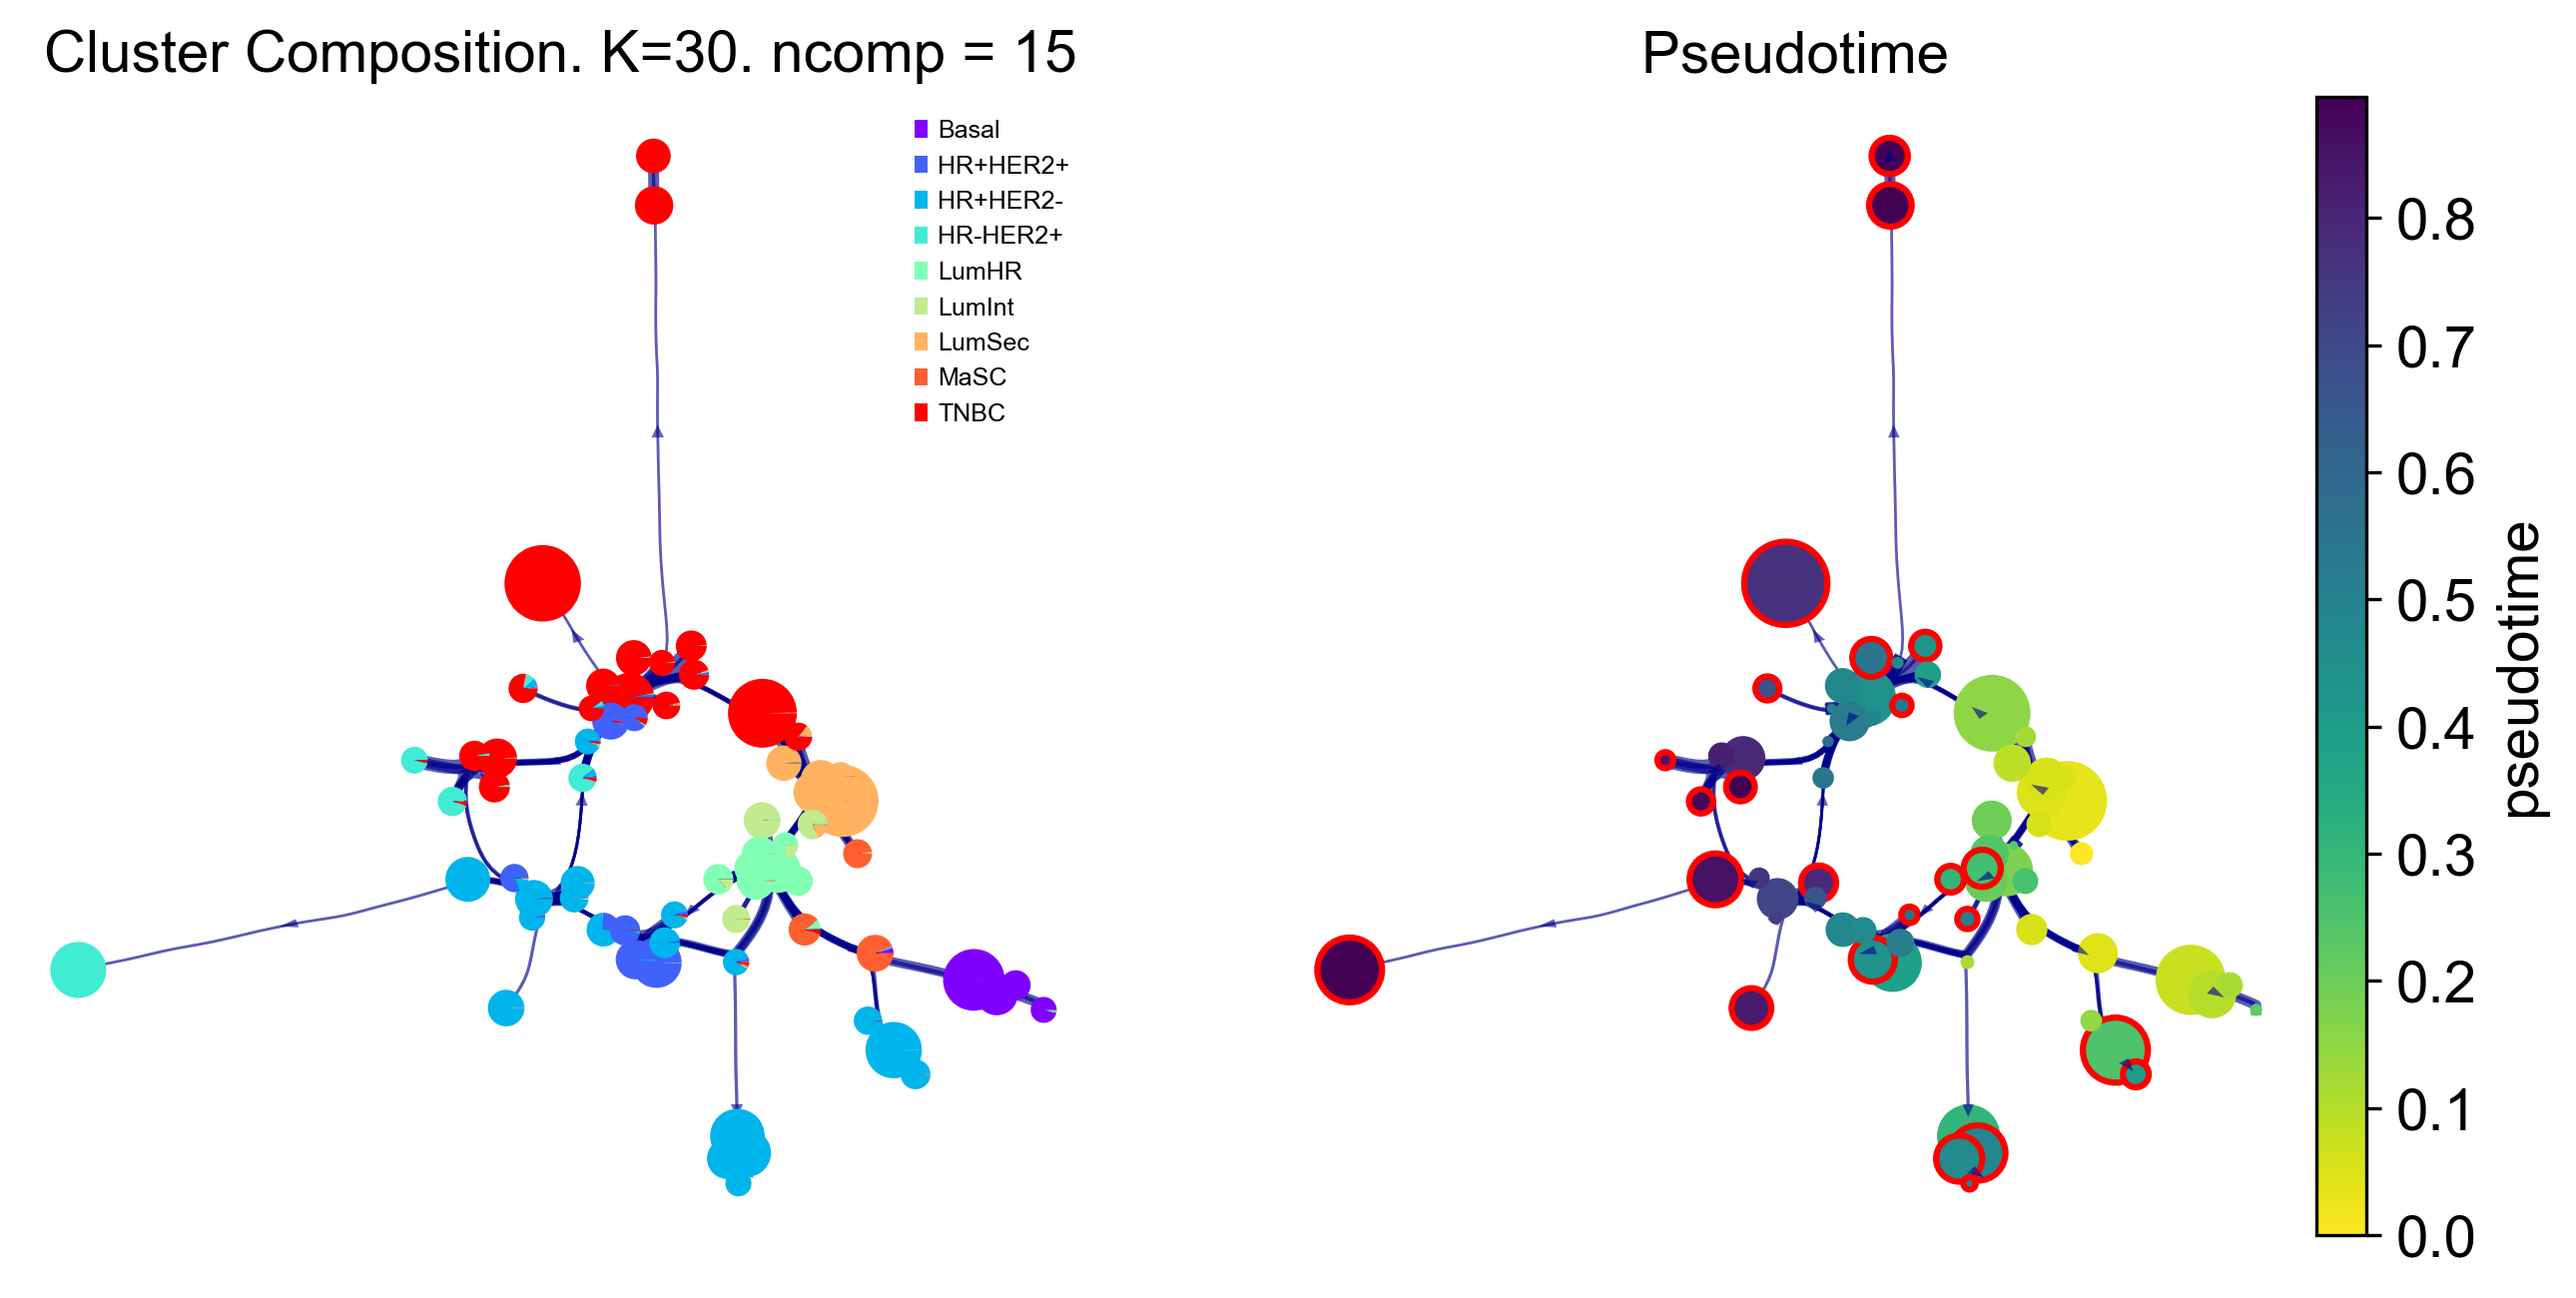

In [ ]:
print(f'{datetime.now()}\tPlot Via2.0 cluster graph')

# f, ax, ax1=via.plot_piechart_viagraph(via_object=v0, cmap_piechart='viridis_r', cmap='viridis_r',  reference_labels=cluster_celltype_label, headwidth_arrow=0.4,
#                         highlight_terminal_clusters=True, show_legend=True)
# f.set_size_inches(10, 5)
age_label = [i for i in adata_concat.obs['age']]
study_label = [i for i in adata_concat.obs['study']]
f, ax, ax1=via.plot_piechart_viagraph(via_object=v0, headwidth_arrow=0.4, show_legend=True, ax_text=False, pie_size_scale=0.6, cmap_piechart='rainbow', 
                        highlight_terminal_clusters=True, size_node_notpiechart=0.8)
f.set_size_inches(10, 5)
f.savefig(f'{figpath}/3h.svg')
# f, ax, ax1= via.plot_piechart_viagraph(via_object=v0, cmap_piechart='jet', cmap='plasma',
#                         reference_labels=cluster_celltype_label, headwidth_arrow=0.4,
#                         highlight_terminal_clusters=True,size_node_notpiechart=0.8)
# f.set_size_inches(10, 5)

Area under curve GATA3 for branch HR-HER2+ is 0.176568206158916
Area under curve GATA3 for branch HR+HER2- is 0.3872179070558066
Area under curve GATA3 for branch HR+HER2+ is 0.2730952357901071
Area under curve GATA3 for branch TNBC is 0.09000237686744708
Area under curve CDH1 for branch HR-HER2+ is 0.168668083387514
Area under curve CDH1 for branch HR+HER2- is 0.25895321576886465
Area under curve CDH1 for branch HR+HER2+ is 0.18702866994599243
Area under curve CDH1 for branch TNBC is 0.1363039095062577
Area under curve ERBB2 for branch HR-HER2+ is 0.09021416342014593
Area under curve ERBB2 for branch HR+HER2- is 0.11880888624019317
Area under curve ERBB2 for branch HR+HER2+ is 0.2726260739390497
Area under curve ERBB2 for branch TNBC is 0.07859523987983913
Area under curve SLC7A2 for branch HR-HER2+ is 0.005861116244419266
Area under curve SLC7A2 for branch HR+HER2- is 0.32068030102687817
Area under curve SLC7A2 for branch HR+HER2+ is 0.09755361150673392
Area under curve SLC7A2 for br

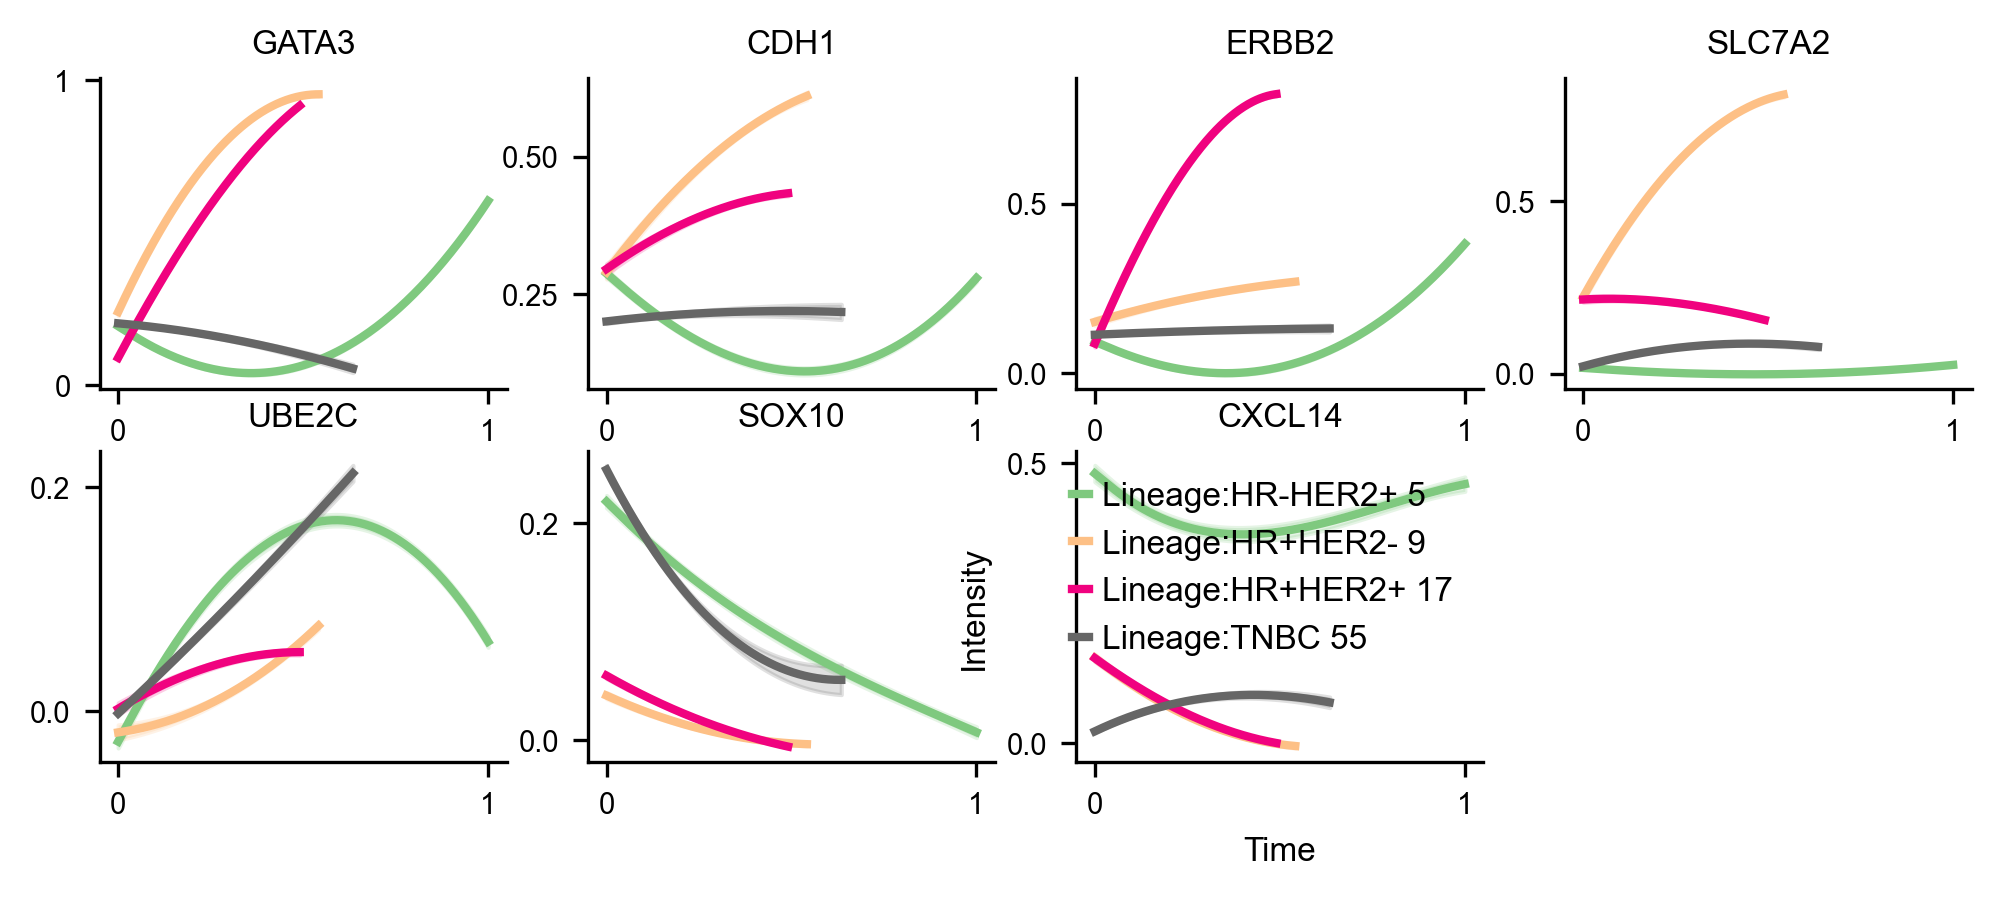

In [ ]:
genes=[ 'GATA3', 'CDH1', 'ERBB2', 'SLC7A2','UBE2C','SOX10', 'CXCL14']
df_genes_sc = pd.DataFrame(adata_concat[:, genes].X.todense(), columns=genes)

select_terminal_clusters = [5, 9, 17, 55]
spline_order = 3
n_splines = 4
fig, axs= via.get_gene_expression(via_object=v0, gene_exp=df_genes_sc, marker_genes=genes,
                        marker_lineages=select_terminal_clusters,  # 56,50,25
                        n_splines=n_splines, spline_order=spline_order, cmap='Accent')
print(memory,'q_memory')
fig.set_size_inches(8, 3)
fig.savefig(f"{figpath}/3l.svg")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

2024-12-24 09:11:06.120562	Start Atlas embedding computation
2024-12-24 09:11:06.120715	Plot Atlas Embedding


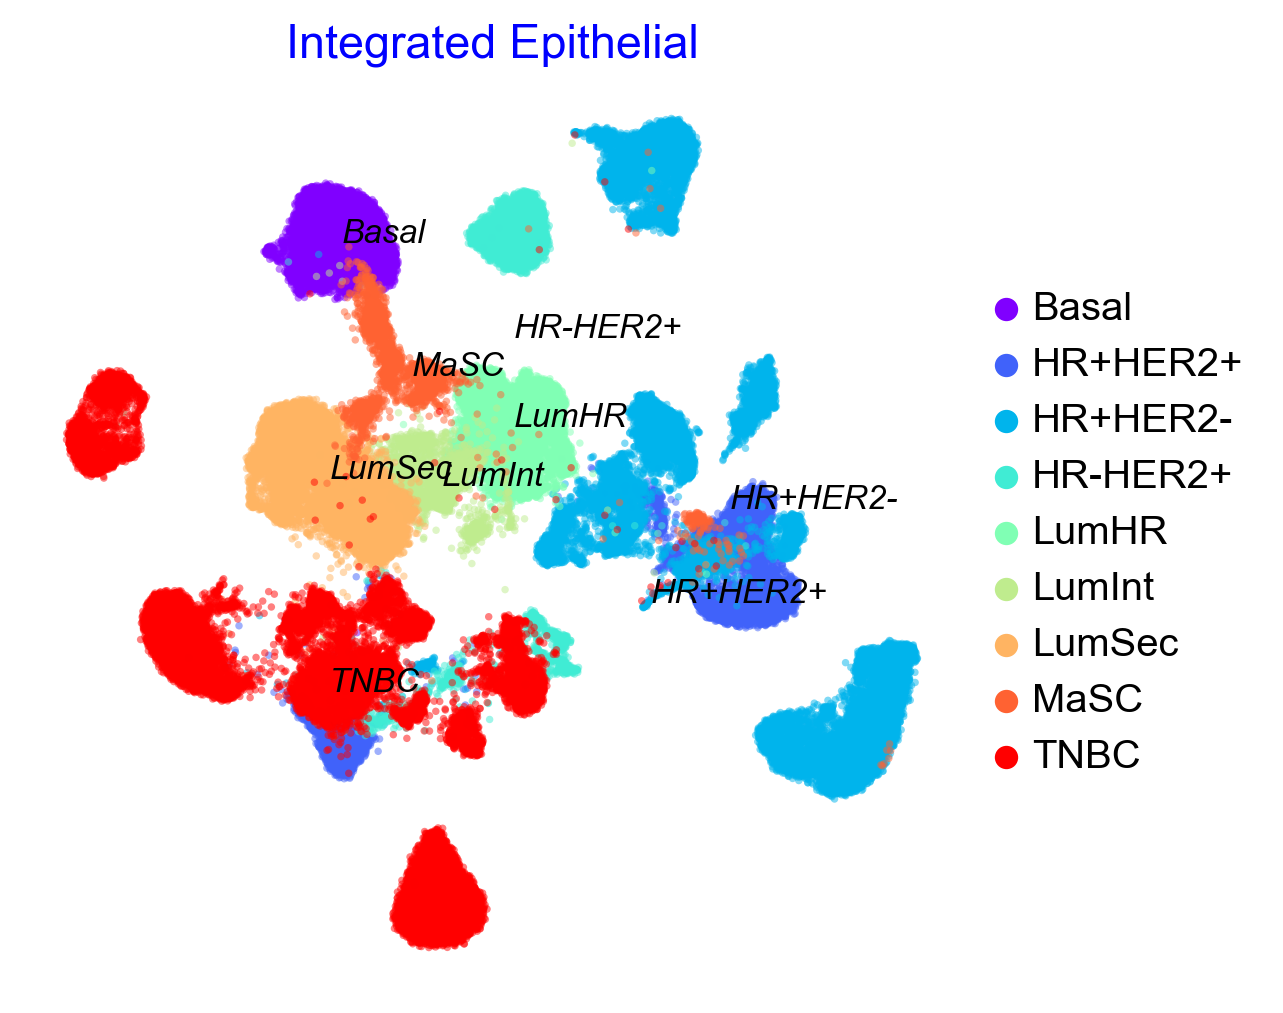

In [ ]:
print(f'{datetime.now()}\tStart Atlas embedding computation')
# compute_atlas_embedding = True
# if compute_atlas_embedding:
#     atlas_embedding = via.via_atlas_emb(via_object=v0, init_pos='via', min_dist=0.2, n_components=3)
# else: atlas_embedding = adata_concat.obsm['X_umap']
atlas_embedding = adata_concat.obsm['X_umap']

print(f'{datetime.now()}\tPlot Atlas Embedding')
# f1, ax = via.plot_scatter(embedding=atlas_embedding, labels=parc_numeric_cluster_labels, cmap='plasma', s=5,
#                           alpha=0.5, edgecolors='None',
#                           title='atlas', text_labels=False)
# f1.set_size_inches(10, 10)

f2, ax = via.plot_scatter(embedding=atlas_embedding, labels=cluster_celltype_label, title='Integrated Epithelial',
                          alpha=0.5, s=5)
f2.set_size_inches(5, 5)
f2.savefig(f"{datapath}/3e.svg")

head df full     pt celltype
0  1.0     TNBC
1  1.0     TNBC
2  1.0     TNBC
3  1.0     TNBC
4  1.0     TNBC
dict temp Counter({'LumSec': 0.792467332820907, 'MaSC': 0.18472969510632847, 'LumInt': 0.018959774532410965, 'Basal': 0.001921598770176787, 'HR+HER2-': 0.001409172431462977, 'TNBC': 0.0003843197540353574, 'LumHR': 0.00012810658467845247})
dict temp Counter({'Basal': 0.562973086627418, 'LumSec': 0.31307821698906646, 'MaSC': 0.07075273338940286, 'LumInt': 0.0398444070647603, 'LumHR': 0.007674516400336417, 'TNBC': 0.004520605550883095, 'HR+HER2-': 0.0009461732548359966, 'HR+HER2+': 0.00010513036164844407, 'HR-HER2+': 0.00010513036164844407})
dict temp Counter({'Basal': 0.3568953568953569, 'HR+HER2-': 0.2972972972972973, 'TNBC': 0.21968121968121967, 'LumInt': 0.04643104643104643, 'LumSec': 0.035343035343035345, 'LumHR': 0.02564102564102564, 'MaSC': 0.016632016632016633, 'HR+HER2+': 0.002079002079002079})
dict temp Counter({'TNBC': 0.5676069394782148, 'LumHR': 0.27506290557542046, 'L

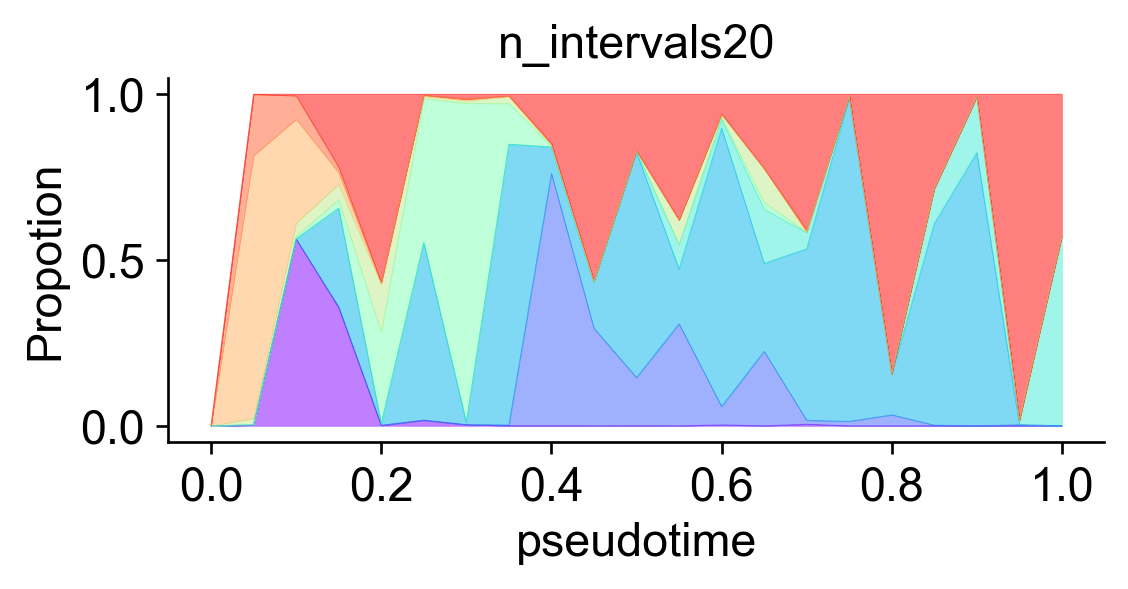

In [ ]:
ax = via.plot_population_composition(v0, xlabel='pseudotime', ylabel='Propotion', legend=False,  title='', cmap='rainbow', n_intervals=20)
ax.figure.set_size_inches(5, 2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.figure.savefig(f'{datapath}/3k.svg')

In [314]:
import os,sys
import PyComplexHeatmap as pch
print(pch.__version__)

1.8.1


In [351]:
import pandas as pd
import numpy as np

def get_topgenes(adata, groupby, n_top=200):
  groups = adata.obs[groupby].unique()
  top_list = []
  for ct in groups:
    top_list.extend(list(pd.DataFrame(adata.uns['rank_genes_groups']['names'])[ct][:n_top]))
  return top_list

def get_degenes(adata, groupby, n_top=200):
  groups = adata.obs[groupby].unique()
  assert len(groups) == 2, 'Please provide two groups'
  up_list = list(pd.DataFrame(adata.uns['rank_genes_groups']['names'])[groups[0]][:n_top])
  down_list = list(pd.DataFrame(adata.uns['rank_genes_groups']['names'])[groups[1]][:n_top])
  down_list.reverse()
  up_list.extend(down_list)
  return up_list

def get_expr(adata, groupby, groups=None, selected_genes=None):
  if groups is None:
    groups = adata.obs[groupby].unique()
  if selected_genes is None:
    selected_genes = adata.var_names
  expr_df = pd.DataFrame(columns=groups)
  for ct in groups:
      adata_cp = adata[:, selected_genes]
      expr = np.array(adata_cp[adata_cp.obs[groupby]==ct].X.mean(axis=0)).flatten()
      expr_df[ct] = expr
  expr_df.index = selected_genes

  frac_df = pd.DataFrame(columns=groups)
  for ct in groups:
      adata_cp = adata[:, selected_genes]
      frac = np.array(np.mean(adata_cp[adata_cp.obs[groupby]==ct].X > 1, axis=0)).flatten()
      frac_df[ct] = frac
  frac_df.index = selected_genes
  return expr_df, frac_df

In [312]:
corr_mt

,Basal,HR+HER2+,HR+HER2-,HR-HER2+,LumHR,LumInt,LumSec,MaSC,TNBC
Basal,1.000000,0.514522,0.481205,0.396965,0.555414,0.684794,0.600933,0.742015,0.584022
HR+HER2+,0.514522,1.000000,0.848288,0.715959,0.774004,0.737939,0.630993,0.554801,0.726740
HR+HER2-,0.481205,0.848288,1.000000,0.748269,0.867372,0.749153,0.596541,0.620922,0.650517
HR-HER2+,0.396965,0.715959,0.748269,1.000000,0.709583,0.652492,0.570736,0.476127,0.725566
LumHR,0.555414,0.774004,0.867372,0.709583,1.000000,0.854007,0.707333,0.726532,0.662667
LumInt,0.684794,0.737939,0.749153,0.652492,0.854007,1.000000,0.848458,0.748278,0.759919
LumSec,0.600933,0.630993,0.596541,0.570736,0.707333,0.848458,1.000000,0.700910,0.738862
MaSC,0.742015,0.554801,0.620922,0.476127,0.726532,0.748278,0.700910,1.000000,0.559315
TNBC,0.584022,0.726740,0.650517,0.725566,0.662667,0.759919,0.738862,0.559315,1.000000


In [384]:
ct_df = pd.DataFrame(list(corr_mt.index), index=corr_mt.index, columns=['Celltype'])

Starting plotting HeatmapAnnotations
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..
Incresing ncol


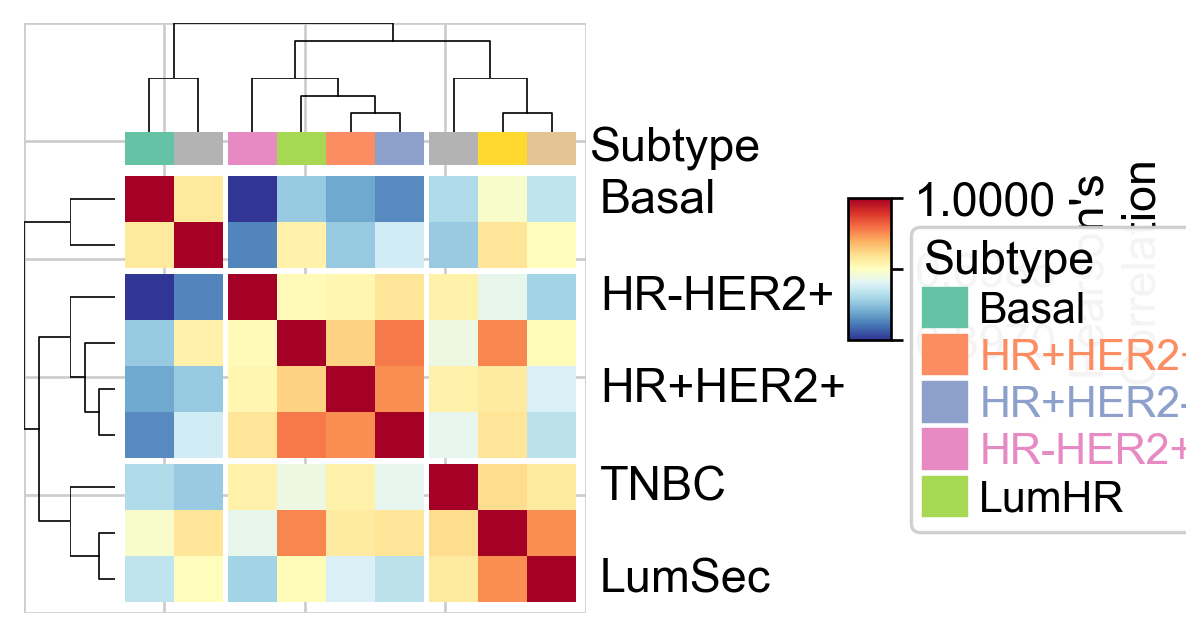

In [ ]:
plt.figure(figsize=(3, 2.7))
row_ha = pch.HeatmapAnnotation(Subtype=pch.anno_simple(ct_df.Celltype, cmap='Set2'),
                               legend=True,legend_gap=5,hgap=1,axis=1)
cm = pch.ClusterMapPlotter(data=corr_mt,
                           top_annotation=row_ha,
                    row_cluster=True,
                    col_cluster=True,
                    # z_score=1,
                    row_split=3,
                    row_split_gap=0.5,
                    col_dendrogram=True, 
                      row_dendrogram=True,
                      col_split=3,#row_split=2,
                      col_split_gap=0.5,# row_split_gap=0.8,
                      show_rownames=True,
                      show_colnames=False,
                      row_names_side='left',
                      cmap='RdYlBu_r',
                      label='Pearson\'s \nCorrelation', 
                      tree_kws={'colors':'black'},verbose=0,legend_gap=5,
                      )
plt.savefig(f'{datapath}/3f.svg', bbox_inches='tight')
plt.show()

In [ ]:
ha_df = adata_concat.obs.groupby('batch')['age'].first().reset_index()
ha_df = pd.concat([ha_df, adata_concat.obs.groupby('batch')['IHC'].first().reset_index()['IHC']], axis=1)
ha_df.index = ha_df.batch
ha_df = ha_df.sort_values(by='age')
ha_df

In [349]:
adata_concat.obs['annotation'].cat.categories

Index(['Basal', 'HR+HER2+', 'HR+HER2-', 'HR-HER2+', 'LumHR', 'LumInt',
       'LumSec', 'MaSC', 'TNBC'],
      dtype='object')

In [367]:
la_df = pd.DataFrame(['Benign', 'Malignant', 'Malignant', 'Malignant','Benign','Benign','Benign','Benign','Malignant',],
                     index=['LumSec','TNBC', 'HR+HER2+', 'HR+HER2-', 'LumHR','Basal','LumInt','MaSC','HR-HER2+',])

Starting plotting HeatmapAnnotations


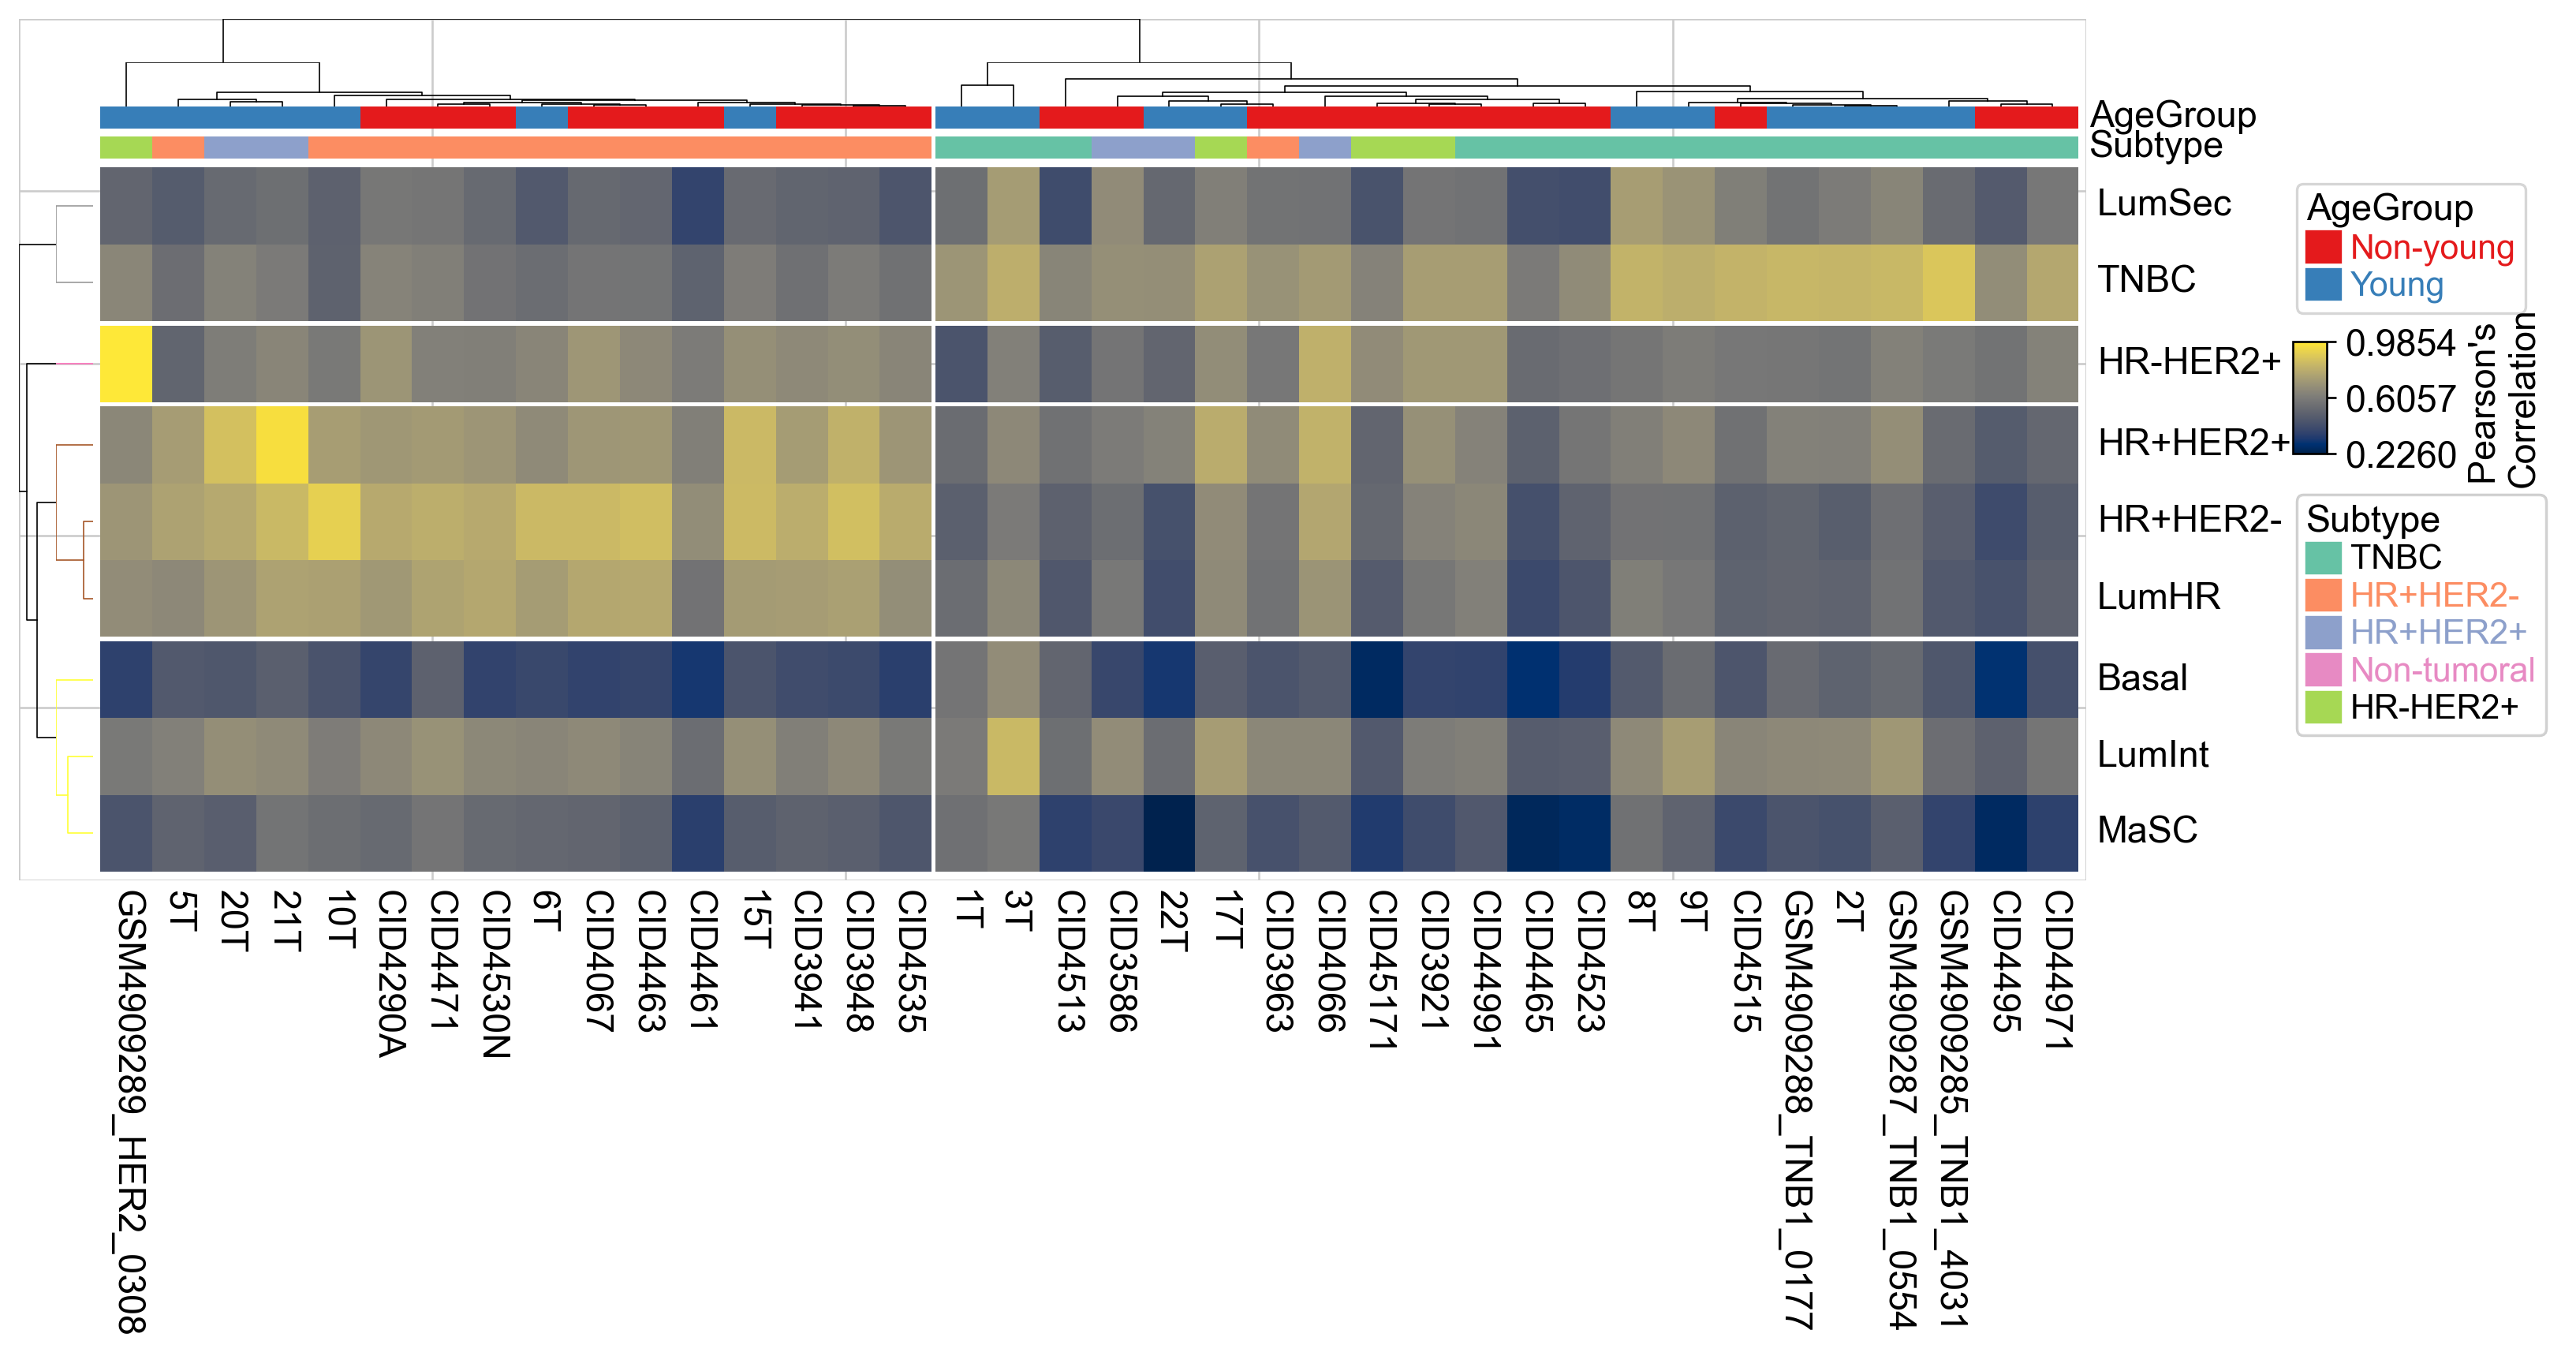

In [ ]:
plt.figure(figsize=(14, 5))
col_ha = pch.HeatmapAnnotation(AgeGroup=pch.anno_simple(ha_df.age, cmap='Set1'),
                               Subtype=pch.anno_simple(ha_df.IHC, cmap='Set2'),
                               legend=True,legend_gap=5,hgap=1,axis=1)
row_ha = pch.HeatmapAnnotation(Celltype=pch.anno_simple(la_df, cmap='Set3'),
                               legend=True,legend_gap=5,hgap=1,axis=1)
cm = pch.ClusterMapPlotter(data=corr_df1,
                    top_annotation=col_ha,
                    row_cluster=True,
                    col_cluster=True,
                    # z_score=1,
                    row_split=4,
                    row_split_gap=0.5,
                    col_dendrogram=True, 
                    row_dendrogram=True,
                    col_split=2,#row_split=2,
                    col_split_gap=0.5,# row_split_gap=0.8,
                      show_rownames=True,
                      show_colnames=True,
                      row_names_side='left',
                      cmap='cividis',
                      label='Pearson\'s \nCorrelation', 
                      tree_kws={'row_cmap': 'Set1_r','colors':'black'},verbose=0,legend_gap=5,
                      )
plt.savefig(f'{figpath}/S3d.svg')
plt.show()

In [342]:
corr_df1 = corr_df[['1T', '2T', '3T', '5T', '6T', '8T', '9T', '10T',
       '15T',  '17T', '20T', '21T', '22T', 'CID3586', 'CID3921',
       'CID3941', 'CID3948', 'CID3963', 'CID4066',
       'CID4067', 'CID4290A', 'CID4461', 'CID4463', 'CID4465',
       'CID4471', 'CID4495', 'CID4513', 'CID4515', 'CID4523', 'CID4530N',
       'CID4535', 'CID44971', 'CID44991', 'CID45171',
       'GSM4909285_TNB1_4031', 'GSM4909287_TNB1_0554', 'GSM4909288_TNB1_0177',
       'GSM4909289_HER2_0308']]

In [330]:
corr_df.columns

Index(['1T', '2T', '3T', '5N', '5T', '6N', '6T', '8T', '9T', '10N', '10T',
       '12N', '15T', '16N', '17T', '20T', '21T', '22T', 'CID3586', 'CID3921',
       'CID3941', 'CID3946', 'CID3948', 'CID3963', 'CID4040', 'CID4066',
       'CID4067', 'CID4290A', 'CID4398', 'CID4461', 'CID4463', 'CID4465',
       'CID4471', 'CID4495', 'CID4513', 'CID4515', 'CID4523', 'CID4530N',
       'CID4535', 'CID44041', 'CID44971', 'CID44991', 'CID45171',
       'GSM4909285_TNB1_4031', 'GSM4909287_TNB1_0554', 'GSM4909288_TNB1_0177',
       'GSM4909289_HER2_0308'],
      dtype='object')

Starting plotting HeatmapAnnotations


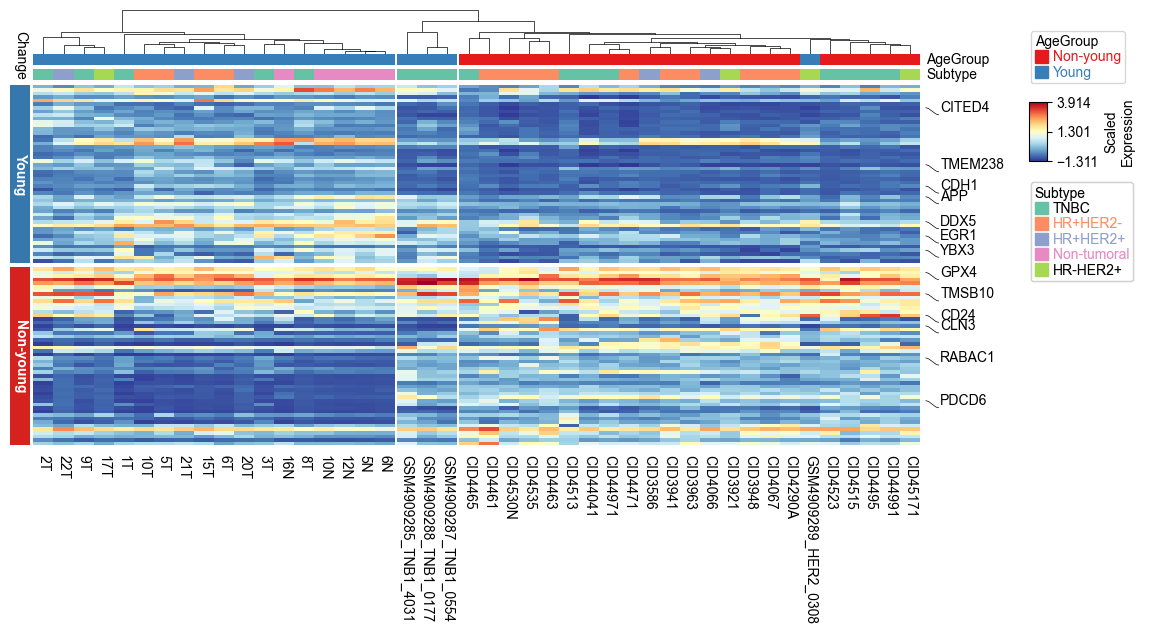

In [444]:
selected_genes = get_degenes(adata_concat, groupby='age', n_top=50)
expr_df, _ = get_expr(adata_concat, groupby='batch', selected_genes=selected_genes)
expr_df = expr_df.drop(['CID4398', 'CID3946', 'CID4040'], axis=1)
ha_df = adata_concat.obs.groupby('batch')['age'].first().reset_index()
ha_df = pd.concat([ha_df, adata_concat.obs.groupby('batch')['IHC'].first().reset_index()['IHC']], axis=1)
ha_df.index = ha_df.batch
ha_df = ha_df.sort_values(by='age')
rank2 = pd.DataFrame(index=expr_df.index, data= ['Young']*50+['Non-young']*50, columns=['Regulation'])
selected_rows = ['CITED4','EGR1','CDH1', 'TMEM238', 'DDX5','TAGLN', 'APP',  'YBX3', 'PDCD6', 'TMSB10', 'CD24','GPX4','CLN3', 'RABAC1']
label_rows = expr_df.apply(lambda x:x.name if x.name in selected_rows else None,axis=1)
plt.figure(figsize=(12, 5))
col_ha = pch.HeatmapAnnotation(AgeGroup=pch.anno_simple(ha_df.age, cmap='Set1'),
                               Subtype=pch.anno_simple(ha_df.IHC, cmap='Set2'),
                               legend=True,legend_gap=5,hgap=1,axis=1)
right_ha = pch.HeatmapAnnotation(
                            selected=pch.anno_label(label_rows,colors='black'),
                            label_side='bottom',
                            axis=0,verbose=0,orientation='right'
                            )
left_ha = pch.HeatmapAnnotation(
                            Change=pch.anno_simple(rank2['Regulation'],colors={'Young': '#3677ad', 'Non-young': '#d5221e'},
                            add_text=True,legend=False,height=5,
                            text_kws={'color':'white', 'fontsize':10,'fontweight':'bold',
                            'rotation':-90,'horizontalalignment':'left'}),
                            axis=0,verbose=0,orientation='right')
cm = pch.ClusterMapPlotter(data=expr_df,
                    top_annotation=col_ha,
                    right_annotation=right_ha,
                    left_annotation=left_ha,
                    row_cluster=True,
                    col_cluster=True,
                    z_score=1,
                    row_split=2,
                    row_split_gap=1,
                    col_dendrogram=True, 
                      row_dendrogram=False,
                      col_split=3,#row_split=2,
                      col_split_gap=0.5,# row_split_gap=0.8,
                      show_rownames=False,
                      show_colnames=True,
                      row_names_side='left',
                      cmap='RdYlBu_r',
                      label='Scaled\nExpression', 
                      tree_kws={'row_cmap': 'Set1_r','colors':'black'},verbose=0,legend_gap=5,
                      )
plt.savefig('figure-12.9/S3a.svg')
plt.show()

In [446]:
selected_genes = get_degenes(adata_concat, groupby='age', n_top=50)
expr_df, _ = get_expr(adata_concat, groupby='age', selected_genes=selected_genes)
ha_df = pd.DataFrame(['Young', 'Non-young'], index=['Young', 'Non-young'], columns=['age'])
rank2 = pd.DataFrame(index=expr_df.index, data= ['Young']*50+['Non-young']*50, columns=['Regulation'])
selected_rows = ['CITED4','EGR1','CDH1', 'TMEM238', 'DDX5','TAGLN', 'APP',  'YBX3', 'PDCD6', 'TMSB10', 'CD24','GPX4','CLN3', 'RABAC1']
label_rows = expr_df.apply(lambda x:x.name if x.name in selected_rows else None,axis=1)

Starting plotting HeatmapAnnotations


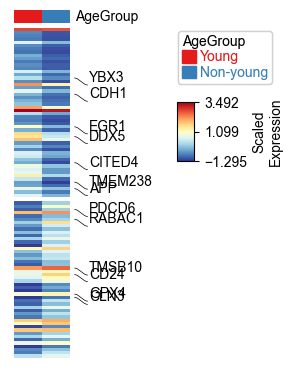

In [ ]:
# Fig.3a-c differential expression genes among young and non-young epithelial
plt.figure(figsize=(1, 4))
col_ha = pch.HeatmapAnnotation(AgeGroup=pch.anno_simple(ha_df.age, cmap='Set1'),
                               legend=True,legend_gap=5,hgap=1,axis=1)
right_ha = pch.HeatmapAnnotation(
                            selected=pch.anno_label(label_rows,colors='black'),
                            label_side='bottom',
                            axis=0,verbose=0,orientation='right'
                            )
cm = pch.ClusterMapPlotter(data=expr_df,
                    top_annotation=col_ha,
                    right_annotation=right_ha,
                    # left_annotation=left_ha,
                    row_cluster=True,
                    col_cluster=True,
                    z_score=1,
                    row_split=0,
                    row_split_gap=1,
                    col_dendrogram=False, 
                    row_dendrogram=False,
                    show_rownames=False,
                    show_colnames=False,
                    row_names_side='left',
                    cmap='RdYlBu_r',
                    label='Scaled\nExpression', 
                    tree_kws={'row_cmap': 'Set1_r','colors':'black'},verbose=0,legend_gap=5,
                    )
plt.savefig(f'{figpath}/3a.svg')
plt.show()